<a href="https://colab.research.google.com/github/luancordeiro/lidarpy/blob/main/raman_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

!git clone https://github.com/luancordeiro/lidarpy.git
os.chdir("lidarpy")

fatal: destination path 'lidarpy' already exists and is not an empty directory.


In [2]:
from lidarpy.data.read_binary import GetData

directory = "/content/lidarpy/lidarpy/tests/data/binary"
files = [file for file in os.listdir(directory) if file.startswith("RM")]

data = GetData(directory, files)
lidar_data = data.get_xarray()

# Removing the background noise and grouping the bins

In [3]:
from lidarpy.data.manipulation import remove_background, groupby_nbins, signal_smoother

nbins = 5

lidar_clean = (lidar_data
               .sel(channel=["355_1", "387_1"])
               .pipe(remove_background, [lidar_data.coords["rangebin"][-1] - 5000, lidar_data.coords["rangebin"][-1]])
               .pipe(groupby_nbins, nbins))

In [4]:
da_raman = (lidar_clean
            .mean("time")
            .isel(rangebin=slice(1100 // nbins, 2400 // nbins))
            .rolling(rangebin=9)
            .mean()
            .dropna("rangebin"))

z_raman = da_raman.coords["rangebin"].data

# Getting the atmospheric data

In [5]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

temperature = f_temp(z_raman)
pressure = f_pres(z_raman)

# Raman inversion

In [6]:
from lidarpy.inversion.raman import Raman

raman = Raman(da_raman,
              355,
              387,
              0,
              pressure,
              temperature,
              [9000, 11_000])

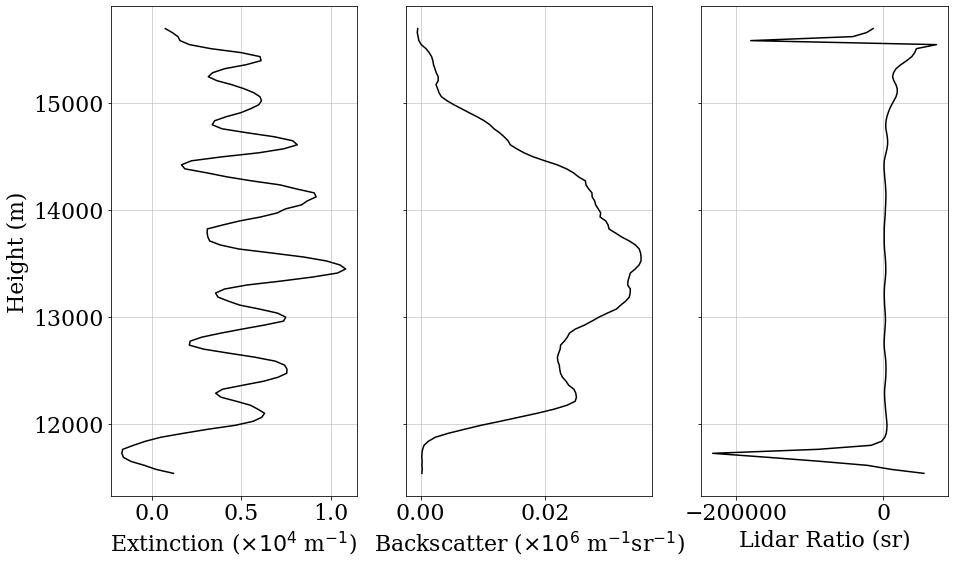

In [7]:
from lidarpy.plot.plotter import plot_3graph_std
from lidarpy.data.raman_smoothers import get_savgol_filter, get_beta_savgol, diff_linear_regression

alpha, beta, lr = raman.fit(diff_strategy=get_savgol_filter(11, 2),
                            diff_window=5,
                            beta_smoother=get_beta_savgol(11, 2))

ind = (z_raman >= 11500) & (z_raman < 15_700)

plot_3graph_std(z_raman[ind], 
                alpha[ind], 
                beta[ind], 
                lr[ind])